In [1]:
import sys
sys.path.append('../')
from smodels.experiment.expAuxiliaryFuncs import maximal_matching
import numpy as np
import networkx as nx
from networkx import bipartite
import numpy
from scipy import sparse
from collections import defaultdict
from bipartitematching import enumMaximumMatching, plotGraph

In [47]:
x = []
y = iter(x)

def f():    
    z = next(y,None)
    if z is None:
        return None
    while z is not None:
        yield z
        z = next(y,None)
    
for zz in y:
    print(zz)

In [26]:
def getCycle(G):
    """
    Given a directed graph G, return a cycle, if it
    exits.
    
    :param G: Dictionary with the directed edges 
              ({A : [B,C,D], B : [],..})
    
    :return: List of nodes generating the cycle.
             The first and last entries are the
             same node.
             ([A,C,D,A])
    """

    
    visited=set()    
    stack = []
    
    def dfs_visit(u):

        # Add u to the current stack of visited nodes
        stack.append(u)                         
        for v in G[u]:
            if v in stack: # A cycle has been found with a path starting and ending in v                
                stack.append(v) # Include v at the end of the stack
                return True
            if v in visited:
                continue
            cycleFound = dfs_visit(v)
            if cycleFound:
                return True
        visited.add(u)
        stack.remove(u)
        return False    
                                 
    for u in G:
        # If u has been visited, it means no cycle 
        # can have u as the initial node, so we can skip it.
        if u in visited: 
            continue
        # Visit all the descendents of u
        # (if any the "family trees" has a node
        # with a descendent which returns to the node, a cycle
        # has been found)
        cycleFound = dfs_visit(u)
        if cycleFound:
            break
    
    if not cycleFound:
        return None

    # If a cycle has been found the cycle is a subset
    # of the current stack (stack = A -> B -> C -> D -> E -> C)
    # where the last entry is the beginning and end of the cycle
    headNode = stack[-1]
    path = stack[stack.index(headNode):]
    
    return path
    
def getNewMatch(left,right,edges,match):
    """
    Given a perfect match, a list of left and right nodes in a bipartite
    graph and their edges (left > right), compute a new match.
    
    :param left: list of left nodes ([nL1,nL2,...])
    :param right: list of right nodes ([nR1,nR2,..])
    :param edges: Dictionary with left->right edges
                  ({nL1 : [nR2,nR3], nL2 : [nR1],...})
    :param match: Dictionary with a perfect matching
                  ({nL1 : nR3, nL2 : nR1,...})
    """
    
    # First define the directed edges
    # (edges in matchDict are left -> right and all the other
    # ones are right -> left)
    edgesL2R,edgesR2L = getDirectedEdges(left,right,edges,match)
    
    # For bookkepping create a dictionary with
    # all nodes and directed edges.
    # In order to distinguish between left and right
    # nodes, convert them to tuples:
    # (0,nL) -> left node, (1,nR) -> right node    
    G = {}
    for nL in left:
        if nL in edgesL2R:
            G[(0,nL)] = [(1,nR) for nR in edgesL2R[nL]]
        else:
            G[(0,nL)] = []
    for nR in right:
        if nR in edgesR2L:
            G[(1,nR)] = [(0,nL) for nL in edgesR2L[nR]]
        else:
            G[(1,nR)] = []
            
    # Find one cyle in the directed graph
    # (if a cycle exists, it means a new match can be created)
    path = getCycle(G)
    if not path:
        return None

    # Create a new match removing the left->right
    # edges in the cycle and replacing them by the right->left
    # edges
    new_match = dict(match.items())
    removeEdges = {}
    addEdges = {}
    for n1,n2 in list(zip(path[:-1],path[1:])):
        if n1[0] == 0: # cycle has left -> right (to be removed)            
            l = n1[1]
            r = n2[1]
            removeEdges[l] = r            
        else: # cycle has right -> left (to be added)
            r = n1[1]
            l = n2[1]
            addEdges[l] = r
    
    for l in removeEdges:
        new_match.pop(l)
        
    new_match.update(addEdges)
    if len(new_match) != len(match):
        raise SModelSError("Error constructing new match dict")
    
    return new_match
    

In [27]:
def getDirectedEdges(left,right,edges,match):    
    """
    From a list of left and right nodes in a bipartite graph
    and a match dictionary, split the edges into left -> right
    (if they appear in the match) and right -> left (otherwise).

    :param left: List of left nodes
    :param right: List of right nodes
    :param edges: Dictionary with all edges between left and right nodes
                  (left nodes as keys and right nodes as values)
    :param match: Dictionary containing the edges for one perfect matching 
                  (left nodes as keys and right nodes as values)
    
    :return: Dictionary of directed edges between left and right nodes
             with edges from matchDict pointing from left to right
             and all the other edges pointing from right to left.
    """

    edgesL2R = {}
    edgesR2L = {}
    
    for nL in edges:
        for nR in edges[nL]:
            if match[nL] == nR:
                if nL not in edgesL2R:
                    edgesL2R[nL] = []
                edgesL2R[nL].append(nR)
            else:
                if nR not in edgesR2L:
                    edgesR2L[nR] = []
                edgesR2L[nR].append(nL)
                
    return edgesL2R,edgesR2L

def getPerfectMatchings(left,right,edges):
    """
    Find all perfect matchings in an undirected bipartite graph.

    :param left: List of left nodes
    :param right: List of right nodes
    :param edges: Dictionary with all edges between left and right nodes
                  (left nodes as keys and right nodes as values)

    :return: list with all matching dictionaries (left nodes as keys and right nodes as values)
    """

    all_matches=[]

    # Find one perfect match
    match = maximal_matching(left,right,edges)
    if len(match) != len(left):
        return []

    match = dict(sorted(match.items()))
    all_matches.append(match)
    # Enter recursion
    all_matches = perfectMatchingIter(left,right,edges,match,all_matches,None)

    return all_matches


def perfectMatchingIter(left,right,edges,match,all_matches,add_e=None):
    """
    Iterate over all perfect matchings.

    :param left: List of left nodes
    :param right: List of right nodes
    :param edges: Dictionary with all edges between left and right nodes
                  (left nodes as keys and right nodes as values)
    :param match: Dictionary with a perfect matching 
                  (left nodes as keys and right nodes as values)
    :param all_matches: list with pertfect matching dicts.
                   Newly found matchings will be appendedinto this list.
    :param add_e: List of tuples with the edges used to form subproblems. If not None,
                  will be added to each newly found matchings.

    :return all_matches: updated list of all perfect matchings.
    """

    # Find a new match using the current match:
    new_match = getNewMatch(left,right,edges,match)

    if new_match is None:
        return all_matches
    else:
        
        # Add previously removed edges to the new match:
        if add_e is not None:
            for e in add_e:
                new_match[e[0]] = e[1]

        # Sort new_match for convenience
        new_match = dict(sorted(new_match.items()))
        all_matches.append(new_match)

        # Choose an edge from the original match not present in the new_match
        nL,nR = (set(match.items()).difference(set(new_match.items()))).pop()
        
        # Form subproblems
        # Create G+ with the nodes nL,nR removed and all of
        # its edges
        left_plus = [n for n in left if n != nL]
        right_plus = [n for n in right if n != nR]
        edges_plus = {n : nList[:] for n,nList in edges.items() if n != nL}
        for n,nList in edges_plus.items():
            if nR not in nList:
                continue
            nList.remove(nR)
            edges_plus[n] = nList[:]
        
        # Create G- with the edge nL->nR removed:
        left_minus = left[:]
        right_minus = right[:]
        edges_minus = {n : nList[:] for n,nList in edges.items()}
        edges_minus[nL].remove(nR)
        
        add_e_new = [(nL,nR)]
        if add_e is not None:
            add_e_new.append(add_e)

        all_matches = perfectMatchingIter(left_minus,right_minus,edges_minus,new_match,all_matches,add_e)
        all_matches = perfectMatchingIter(left_plus,right_plus,edges_plus,match,all_matches,add_e_new)

    return all_matches

In [34]:
left = [1,2,3,4]
right = ['a','b','c','d']
edges = {1 : ['b'], 2 : ['a','c','d'], 3 : ['a','c'], 4 : ['d','a']}
x = getPerfectMatchings(left,right,edges)
print(len(x))

3


In [29]:
g = nx.Graph()
for nL in edges:
    g.add_node(nL,bipartite=0)
    for nR in edges[nL]:
        g.add_node(nR,bipartite=1)
        g.add_edge(nL,nR)
# print(g.nodes)
# print(g.edges)
for m in enumMaximumMatching(g):
    print(m)

[(1, 'b'), (2, 'a'), (3, 'c'), (4, 'd')]
[(1, 'b'), (4, 'a'), (2, 'd'), (3, 'c')]
[(1, 'b'), (3, 'a'), (2, 'c'), (4, 'd')]


In [30]:
edges=[
        [(1,0), (0,0)],
        [(1,0), (0,1)],
        [(1,0), (0,2)],
        [(1,1), (0,0)],
        [(1,2), (0,2)],
        [(1,2), (0,5)],
        [(1,3), (0,2)],
        [(1,3), (0,3)],
        [(1,4), (0,3)],
        [(1,4), (0,5)],
        [(1,5), (0,2)],
        [(1,5), (0,4)],
        [(1,5), (0,6)],
        [(1,6), (0,1)],
        [(1,6), (0,4)],
        [(1,6), (0,6)]
        ]
left = list(set([e[0] for e in edges]))
right = list(set([e[1] for e in edges]))
edgesDict = {nL : [] for nL in left}
for edge in edges:
    nL = edge[0]
    nR = edge[1]
    edgesDict[nL].append(nR)
# print(left)
# print(right)
# print(len(left),len(right))
# print(edgesDict)

4


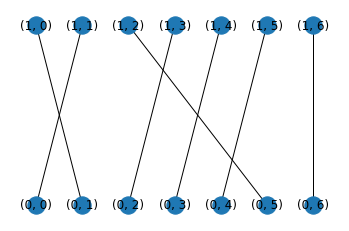

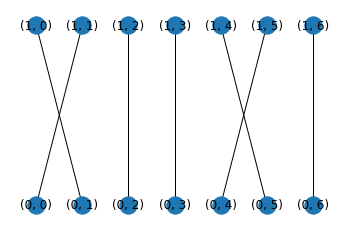

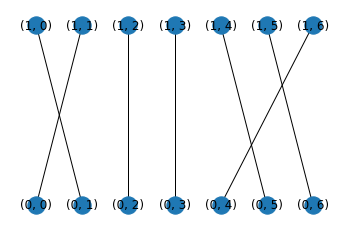

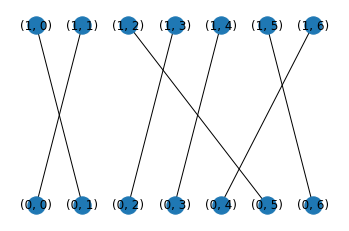

In [31]:
allMatchigns = list(getPerfectMatchings(left,right,edgesDict))
print(len(allMatchigns))
for m in allMatchigns:
    g_match=nx.Graph()
    for nL,nR in m.items():
        g_match.add_edge(nL,nR)
    plotGraph(g_match)
    
#     print(len(set(m.keys())) == len(m.keys())==len(left))
#     print(len(set(m.values())) == len(m.values())==len(right))
    

In [32]:
for im,m in enumerate(allMatchigns):
    for jm,mm in enumerate(allMatchigns):
        if im == jm:
            continue
        if m == mm:
            print(im,jm,'equal')

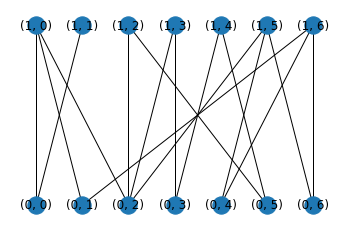

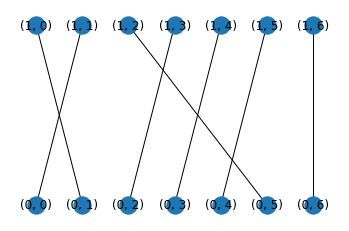

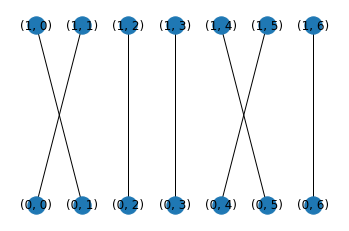

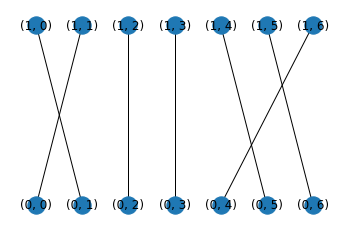

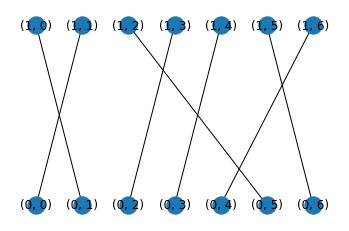

In [122]:
g=nx.Graph()
edges=[
        [(1,0), (0,0)],
        [(1,0), (0,1)],
        [(1,0), (0,2)],
        [(1,1), (0,0)],
        [(1,2), (0,2)],
        [(1,2), (0,5)],
        [(1,3), (0,2)],
        [(1,3), (0,3)],
        [(1,4), (0,3)],
        [(1,4), (0,5)],
        [(1,5), (0,2)],
        [(1,5), (0,4)],
        [(1,5), (0,6)],
        [(1,6), (0,1)],
        [(1,6), (0,4)],
        [(1,6), (0,6)]
        ]

for ii in edges:
    g.add_node(ii[0],bipartite=0)
    g.add_node(ii[1],bipartite=1)

g.add_edges_from(edges)
plotGraph(g)

all_matches=enumMaximumMatching(g)

for mm in all_matches:
    if len(mm) != len(g.nodes)/2:
        continue
    g_match=nx.Graph()
    for ii in mm:
        g_match.add_edge(ii[0],ii[1])
    plotGraph(g_match)
